In [1]:
import os
import json
import requests
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv


_: bool = load_dotenv(find_dotenv())

FMP_API_KEY: str | None = os.environ.get("FMP_API_KEY")
OPENAI_API_KEY: str | None = os.environ.get("OPENAI_API_KEY")
client: OpenAI = OpenAI()

In [2]:
def get_income_statement(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())


def get_balance_sheet(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())


def get_cash_flow_statement(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period=annual&apikey=ETZqiw9M5ObXGLxKylHzoI5Ec70NQFue"
    response = requests.get(url)
    return json.dumps(response.json())


def get_key_metrics(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())


def get_financial_ratios(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/ratios-ttm/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())


def get_financial_growth(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/financial-growth/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())

In [3]:
# Map available functions
available_functions = {
    "get_income_statement": get_income_statement,
    "get_balance_sheet": get_balance_sheet,
    "get_cash_flow_statement": get_cash_flow_statement,
    "get_key_metrics": get_key_metrics,
    "get_financial_ratios": get_financial_ratios,
    "get_financial_growth": get_financial_growth,
}

In [4]:
from openai.types.beta import Assistant
from openai.types.beta.thread import Thread

from openai.types.beta.threads.thread_message import ThreadMessage
from openai.types.beta.threads.run import Run
from openai.types.beta.threads.required_action_function_tool_call import (
    RequiredActionFunctionToolCall,
)
from openai.types.beta.threads.run_submit_tool_outputs_params import ToolOutput
from openai.types.beta.assistant_create_params import Tool
import time
from typing import Literal, List


class FinancialAssistantManager:
    def __init__(self, model: str = "gpt-3.5-turbo-1106"):
        self.client = OpenAI()
        self.model = model
        self.assistant: Assistant
        self.thread: Thread
        self.message: ThreadMessage
        self.run: Run

    def create_assistant(
        self, name: str, instructions: str, tools: list[Tool]
    ) -> Assistant:
        self.assistant = self.client.beta.assistants.create(
            name=name, instructions=instructions, tools=tools, model=self.model
        )
        return self.assistant

    def retrieve_assistant(
        self, id: str
    ) -> Assistant:
        self.assistant = self.client.beta.assistants.retrieve(
            assistant_id=id
        )
        return self.assistant

    def create_thread(self) -> Thread:
        self.thread = self.client.beta.threads.create()
        return self.thread

    def add_message_to_thread(self, role: Literal["user"], content: str) -> None:
        self.message = self.client.beta.threads.messages.create(
            thread_id=self.thread.id, role=role, content=content
        )

    def get_all_messages(self):
        messages = self.client.beta.threads.messages.list(thread_id=self.thread.id)
        return messages

    def run_assistant(self) -> Run:
        self.run = self.client.beta.threads.runs.create(
            thread_id=self.thread.id,
            assistant_id=self.assistant.id,
        )
        return self.run

    def call_required_functions(
        self, required_actions: List[RequiredActionFunctionToolCall]
    ) -> None:
        tool_outputs: List[ToolOutput] = []

        for action in required_actions:
            function_name = action.function.name
            arguments = json.loads(action.function.arguments)
            print("function_name", function_name)
            print("function_arguments", arguments)

            if function_name in available_functions:
                function_to_call = available_functions[function_name]
                output = function_to_call(**arguments)
                tool_outputs.append(
                    {
                        "tool_call_id": action.id,
                        "output": output,
                    }
                )

            else:
                raise ValueError(f"Unknown function: {function_name}")

        print("Submitting outputs back to the Assistant...")
        self.client.beta.threads.runs.submit_tool_outputs(
            thread_id=self.thread.id, run_id=self.run.id, tool_outputs=tool_outputs
        )

    def wait_for_completion(self, run: Run):
        while run.status not in ["completed", "failed"]:
            run_status = self.client.beta.threads.runs.retrieve(
                thread_id=self.thread.id, run_id=self.run.id
            )
            print(f"Run is {run.status}. Waiting...")
            time.sleep(3)  # Wait for 3 seconds before checking again

            if run_status.status == "completed":
                processed_response = self.get_all_messages()
                return processed_response

            elif run_status.status == "requires_action":
                print("Function Calling ...")
                if run_status.required_action:
                    if (
                        run_status.required_action.submit_tool_outputs
                        and run_status.required_action.submit_tool_outputs.tool_calls
                    ):
                        self.call_required_functions(
                            run_status.required_action.submit_tool_outputs.tool_calls
                        )
            elif run.status == "failed":
                print("Run failed.")
                break
            else:
                print(f"Waiting for the Assistant to process...: {run.status}")

In [5]:
import requests
from PIL import Image
from IPython.display import Image


def download_and_save_image(file_id: str, save_path: str) -> None:
    
    # Download an image from OpenAI using its file ID and saves it to the specified path.
    
    # Construct the URL to download the image
    download_url = f"https://api.openai.com/v1/files/{file_id}/content"

    # Perform the HTTP GET request to download the image
    response = requests.get(
        download_url, headers={"Authorization": f"Bearer {OPENAI_API_KEY}"}
    )

    # Check if the request was successful
    if response.status_code == 200:
        # Write the image to the specified file
        with open(save_path, "wb") as file:
            file.write(response.content)
        print(f"Image downloaded and saved to {save_path}")
    else:
        print(f"Failed to download image: HTTP Status Code {response.status_code}")

In [6]:
financial_tools: List[Tool] = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "get_income_statement",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_balance_sheet",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_cash_flow_statement",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_key_metrics",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_financial_ratios",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_financial_growth",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            },
        },
    },
]

## Creating a Financial Assistant Instance


In [7]:
financial_assistant = FinancialAssistantManager()

## Creating An Assistant


In [8]:
financial_assistant.create_assistant(
    name="Financial Analyst",
    instructions="Act as a financial analyst by accessing financial data through the Financial Modeling Prep API. Your capabilities include analyzing key metrics, comprehensive financial statements, vital financial ratios, and tracking financial growth trends",
    tools=financial_tools,
)

Assistant(id='asst_0Ls6ClleYNppKXyEfrzU33Dj', created_at=1702406828, description=None, file_ids=[], instructions='Act as a financial analyst by accessing financial data through the Financial Modeling Prep API. Your capabilities include analyzing key metrics, comprehensive financial statements, vital financial ratios, and tracking financial growth trends', metadata={}, model='gpt-3.5-turbo-1106', name='Financial Analyst', object='assistant', tools=[ToolCodeInterpreter(type='code_interpreter'), ToolFunction(function=FunctionDefinition(name='get_income_statement', parameters={'type': 'object', 'properties': {'ticker': {'type': 'string'}}, 'required': ['ticker']}, description=None), type='function'), ToolFunction(function=FunctionDefinition(name='get_balance_sheet', parameters={'type': 'object', 'properties': {'ticker': {'type': 'string'}}, 'required': ['ticker']}, description=None), type='function'), ToolFunction(function=FunctionDefinition(name='get_cash_flow_statement', parameters={'typ

## Create A Thread


In [9]:
financial_assistant.create_thread()

Thread(id='thread_5PBly8ChFFiP1EurqJSNjTMP', created_at=1702406829, metadata={}, object='thread')

## Add Prompt to the thread


In [10]:
prompt = "Can you compare the financial health of Microsoft and Apple over the last four years, focusing on their balance sheets and key financial ratios?"

In [11]:
financial_assistant.add_message_to_thread(role="user", content=prompt)

## Run The Assistant


In [12]:
run_assistant = financial_assistant.run_assistant()

## Wait for Response


In [13]:
response = financial_assistant.wait_for_completion(run=run_assistant)

Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Function Calling ...
function_name get_balance_sheet
function_arguments {'ticker': 'MSFT'}
function_name get_balance_sheet
function_arguments {'ticker': 'AAPL'}
function_name get_financial_ratios
function_arguments {'ticker': 'MSFT'}
function_name get_financial_ratios
function_arguments {'ticker': 'AAPL'}
Submitting outputs back to the Assistant...
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiti

## Display the Response


In [14]:
from typing import Any


def show_json(obj: Any) -> None:
    data = json.loads(obj.model_dump_json())["data"]
    try:
        for message in reversed(data):
            role_label = "User" if message["role"] == "user" else "Assistant"
            for content in message["content"]:
                if content["type"] == "text":
                    message_content = content["text"]["value"]
                    print(f"{role_label}: {message_content}\n")
                elif content["type"] == "image_file":
                    # Handle image file content, e.g., print the file ID or download the image
                    image_file_id = content["image_file"]["file_id"]
                    # Define a path to save the image
                    image_save_path = f"image_{image_file_id}.png"
                    # Download and save the image
                    print(f"{role_label}: Image file ID: {image_file_id}")
                    download_and_save_image(image_file_id, image_save_path)
                    # Display the image within Jupyter Notebook
                    display(Image(filename=image_save_path)) # type: ignore
        # display(data)
    except (AttributeError, json.JSONDecodeError, TypeError) as e:
        print(f"Error displaying JSON: {e}")


show_json(response)
# print(response.model_dump_json())

User: Can you compare the financial health of Microsoft and Apple over the last four years, focusing on their balance sheets and key financial ratios?

Assistant: I have retrieved the balance sheet and key financial ratios for both Microsoft (MSFT) and Apple (AAPL) for the last four years. Now, I will analyze and compare the financial health of both companies based on this data.

Assistant: The balance sheet data and key financial ratios for Microsoft and Apple reveal some interesting insights.

### Balance Sheet Analysis
1. Microsoft:
   - Total assets have been consistently increasing, indicating growth and expansion.
   - Total liabilities have also been increasing, but proportionally less than the assets, resulting in a growing stockholders' equity.

2. Apple:
   - Total assets have shown a steady increase over the years, reflecting growth and investment.
   - Total liabilities have also increased, but stockholders' equity has grown at a higher rate, indicating improved financial h

## Display Financial Report With Images

In [15]:
financial_assistant.add_message_to_thread(
    role="user", content="Now Visualize the results with one or more charts."
)

## Run The Assistant

In [16]:
run_assistant = financial_assistant.run_assistant()

# Get and Display the response

Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
User: Can you compare the financial health of Microsoft and Apple over the last four years, focusing on their balance sheets and key financial ratios?

Assistant: I have retrieved the balance sheet and key financial ratios for both Microsoft (MSFT) and Apple (AAPL) for the last four years. Now, I will analyze and compare the financial health of both companies based on this data.

Assistant: The balance sheet data and key financial ratios for Microsoft and Apple reveal some interesting insights.

### Balance Sheet Analysis
1.

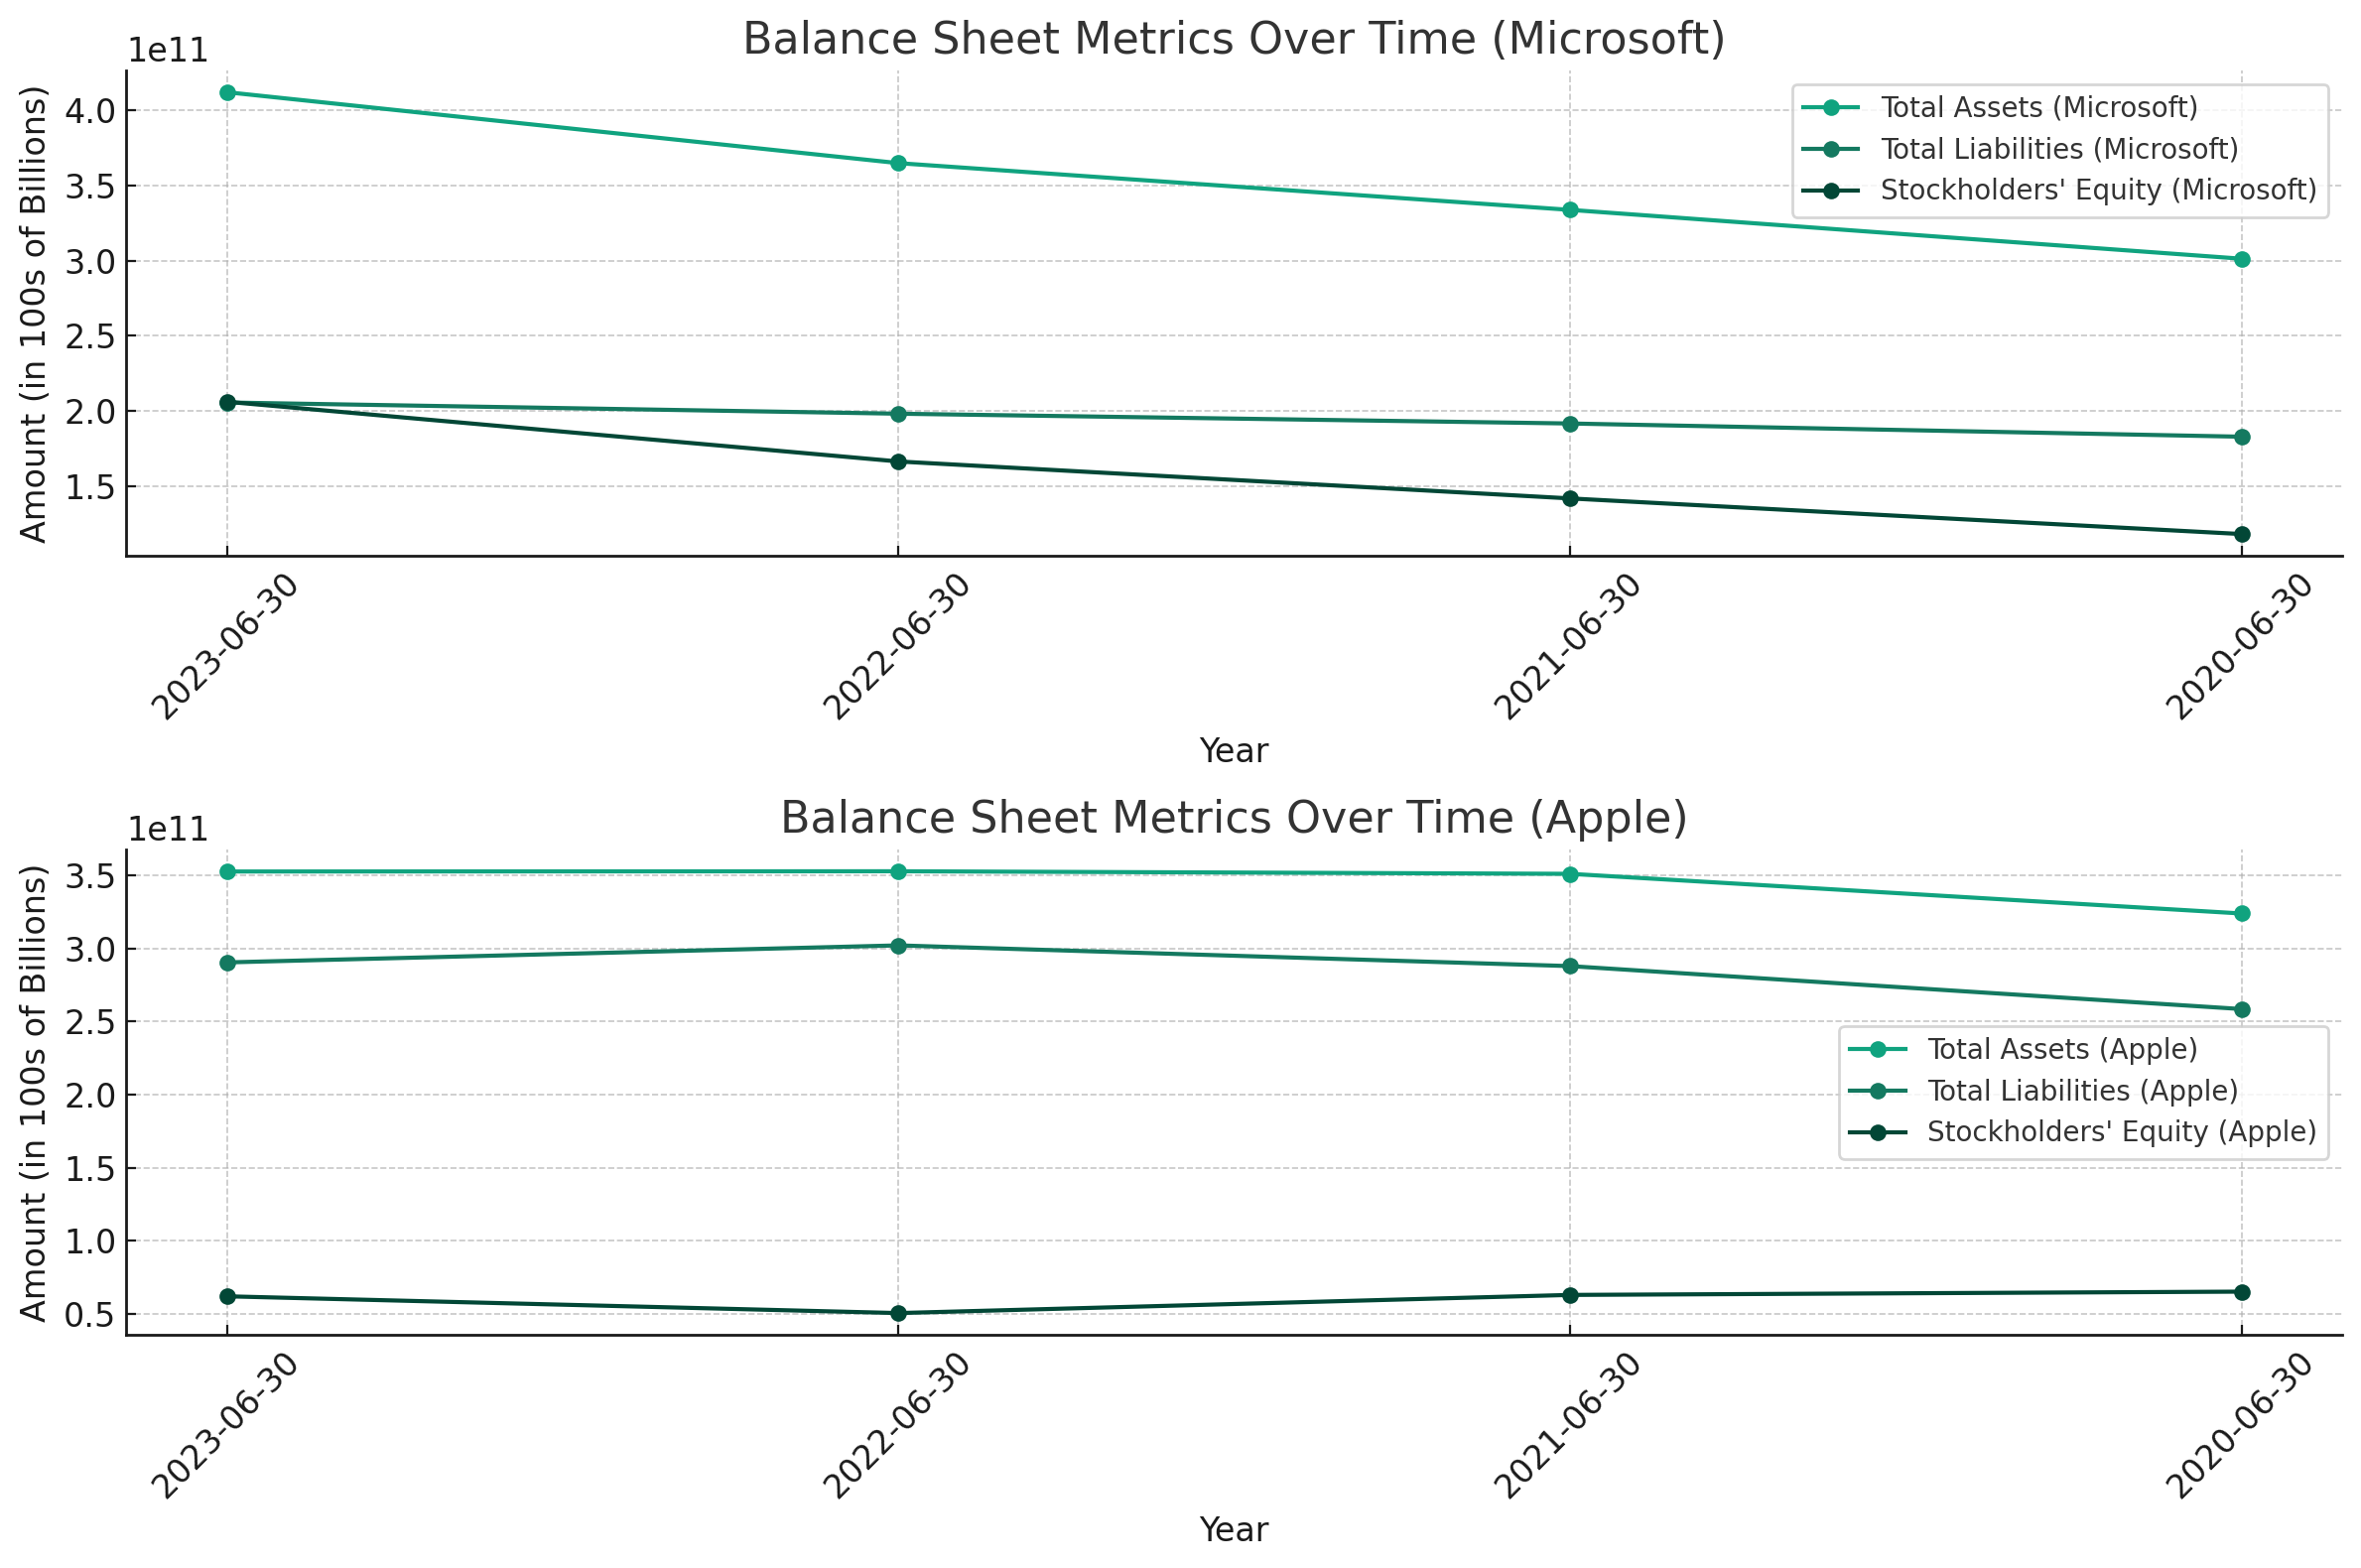

Assistant: Here are the visualizations of the balance sheet metrics over time for both Microsoft and Apple. The charts provide a clear representation of the total assets, total liabilities, and stockholders' equity for each company over the last four years.

Would you like to explore any other financial metrics or ratios for these companies?



In [17]:
response = financial_assistant.wait_for_completion(run=run_assistant)
show_json(response)